In [3]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import covariance_generation
import transformation_constants
import data_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity_skinny.csv'
# dr3_path ='/home/svenpoder/DATA/Gaia_DR3/GaiaDR3_RV_RGB_fidelity.csv'
# dr3_path ='/local/sven/v0_project_archive/GaiaDR3_RV_RGB_fidelity.csv'
gaia_dr3 = pd.read_csv(dr3_path)

# OLD DISTANCE ESTIMATE
# r_est_error = (gaia_dr3.B_rpgeo - gaia_dr3.b_rpgeo)/2
# gaia_dr3['r_est_error'] = r_est_error

# SWAP FOR GSPPHOT
r_est = gaia_dr3.Dist                                               
gaia_dr3['r_est'] = r_est 
r_est_error = (gaia_dr3.B_Dist - gaia_dr3.b_Dist)/2                 
gaia_dr3['r_est_error'] = r_est_error 


# columns_to_drop = ['Unnamed: 0', 'Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
#        '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
#        'RADEcorJ2000', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
#        'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'Gmag', 'BPmag', 'RPmag', 'BP-RP']
# gaia_dr3 = gaia_dr3.drop(columns=columns_to_drop)

parallax_over_error = gaia_dr3.parallax/gaia_dr3.parallax_error
gaia_dr3['parallax_over_error'] = parallax_over_error

print(gaia_dr3.columns)

def load_galactic_parameters():
   '''The load_galactic_parameters function sets the initial galactocentric distance, height over the Galactic plane, and solar vector used in the coordinate transformations.'''

   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59

   return r_0, z_0, v_sun

def apply_initial_cut(icrs_data):

   r_0, z_0, v_sun = load_galactic_parameters()

   galcen_data = data_analysis.get_transformed_data(icrs_data,
                                          include_cylindrical = True,
                                          z_0 = z_0,
                                          r_0 = r_0,
                                          v_sun = v_sun,
                                          debug = True,
                                          is_bayes = True,
                                          is_source_included = True)

   print("Galactocentric data shape: {}".format(galcen_data.shape))
   galcen_data['parallax_over_error'] = icrs_data.parallax_over_error[galcen_data.source_id == icrs_data.source_id]

   galactocentric_cov = covariance_generation.generate_galactocentric_covmat(icrs_data, 
                                                               is_bayes = True,
                                                               Z_0 = z_0,
                                                               R_0 = r_0)

   cyl_cov = covariance_generation.transform_cov_cylindirical(galcen_data, 
                                                C = galactocentric_cov,
                                                Z_0 = z_0,
                                                R_0 = r_0)
   galcen_data = galcen_data.merge(cyl_cov, on='source_id')

   print("Galactocentric data shape after merge with covariance info: {}".format(galcen_data.shape))


   # Final data cut
   galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
   print("Galactocentric data shape after constraining region in z: {}".format(galcen_data.shape))
   galcen_data = galcen_data[(galcen_data.r < 14000) & (galcen_data.r > 5000)]
   print("Galactocentric data shape after constraining region in r: {}".format(galcen_data.shape))

   # Remove halo stars (condition taken from 1806.06038)                        
   v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                        axis=0)                                               
   galcen_data['v_dif'] = v_dif                                                 
   galcen_data = galcen_data[galcen_data.v_dif<210.]

   print("Galactocentric data shape after removing halo stars: {}".format(galcen_data.shape))

   # Remove noisy distances
   print("Removing noisy distances")
   galcen_data = galcen_data[galcen_data.parallax_over_error > 20]
   galcen_data = galcen_data.drop(columns=['parallax_over_error'])

   print("Galactocentric data shape after removing noisy distances: {}".format(galcen_data.shape))

   galcen_data.reset_index(inplace=True, drop=True)
   
   return galcen_data

galcen_data = apply_initial_cut(gaia_dr3)

print(galcen_data.shape)

gaia_dr3 = gaia_dr3.merge(galcen_data, on='source_id')[gaia_dr3.columns]



Index(['Unnamed: 0', 'Unnamed: 0.1', 'source_id', 'ra', 'dec', 'rgeo',
       'b_rgeo', 'B_rgeo', 'r_est', 'b_rpgeo', 'B_rpgeo', 'ra_error',
       'dec_error', 'parallax', 'parallax_error', 'PM', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error',
       'Dist', 'ra_dec_corr', 'ra_pmdec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'b_Dist', 'B_Dist', 'dec_pmra_corr', 'dec_pmdec_corr',
       'dec_parallax_corr', 'parallax_pmdec_corr', 'parallax_pmra_corr',
       'pmra_pmdec_corr', 'r_est_error', 'parallax_over_error'],
      dtype='object')
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 5.3985275672748685 sec
Galactocentric data shape: (6586329, 11)
Galactocentric data shape after merge with covariance info: (6586329, 14)
Galactocentric data shape after constraining region in z: (2099189, 14)
Galactocentric data shape after constraining region in r: (2015056, 14)
Ga

In [2]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                        theta = (0, 1),
                                                        BL_r_min = 5000,
                                                        BL_r_max = 14000,
                                                        BL_z_min = -200,
                                                        BL_z_max = 200,
                                                        N_bins = (9, 1),
                                                        r_drift = False,
                                                        debug = False)

bin_collection.merge_bins([-2, -1])

(12000.0, 14000.0)
(-200.0, 200.0)


In [2]:
r_min = 5000/8277
r_max = 14000/8277
r_0 = 8277
# # Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                    theta = r_0,
                                                    BL_r_min = r_min,
                                                    BL_r_max = r_max,
                                                    BL_z_min = -200,
                                                    BL_z_max = 200,
                                                    N_bins = (9, 1),
                                                    r_drift = True,
                                                    debug = False)

In [3]:
bin_collection.bins[-1].data

,x,y,z,v_x,v_y,v_z,r,phi,v_r,v_phi,source_id,sig_vphi,sig_vr,v_dif,Bin_index
0,-12065.073752,391.545358,-98.806771,41.000357,182.187813,-3.987962,12071.425450,3.109151,-35.069391,-183.421827,180929002037338112,0.133770,0.324607,76.527222,25
1,-12164.587636,613.830562,-102.043371,-5.667935,243.158439,-16.087676,12180.064873,3.091175,17.915025,-242.563814,182380361684009600,0.634735,2.925878,30.979557,25
2,-12347.259253,423.672086,-14.258263,16.519142,225.847978,34.089358,12354.525855,3.107293,-8.764452,-226.281629,182457529358759040,0.402039,0.277375,36.573359,25
3,-12379.541524,464.265687,14.331783,43.083023,214.726007,-16.632229,12388.244063,3.104108,-35.005619,-216.189758,182620536257428608,2.379534,3.180836,54.876234,25
4,-12167.941838,630.600843,-70.951403,41.081204,218.005305,-13.730960,12184.271254,3.089814,-29.743212,-219.839304,183899096479586560,0.805284,0.689957,50.189565,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,-12983.251105,2137.037861,-188.691222,-20.422530,219.250980,35.352959,13157.953491,2.978456,55.760836,-213.023006,233832248826944384,0.220899,1.808784,52.439729,25
305,-12984.281006,-2839.719230,-21.934882,-34.944806,244.196435,14.140665,13291.183489,-2.926278,-18.035726,-246.023883,3125741447002381568,0.303068,0.862456,46.949718,25
306,-13447.787858,-2283.125251,-134.060269,-60.445200,249.722085,-3.811962,13640.222109,-2.973419,17.793510,-256.316471,3324644165618715648,0.535628,0.427203,72.633913,25
307,-13024.530479,-1349.310219,197.063231,-1.050054,193.946341,-25.703001,13094.236605,-3.038363,-18.940953,-193.022088,3368950184951162752,0.232329,0.341833,68.088599,25


In [4]:
import helper_functions as helpfunc

In [5]:
mean_rot_vel = []
rot_vel_error = []

mean_rad_vel = []
rad_vel_error = []

median_rad_vel = []

bootstrap_vphi_error = []
bootstrap_vr_error = []

bin_rs = []
for i, bin in enumerate(bin_collection.bins):

    bin_rs.append(np.mean(bin.r_boundaries))

    bootstrap_vphi_error.append(helpfunc.bootstrap_weighted_error(bin.data.v_phi.to_numpy(), bin.data.sig_vphi.to_numpy()))
    bootstrap_vr_error.append(helpfunc.bootstrap_weighted_error(bin.data.v_r.to_numpy(), bin.data.sig_vr.to_numpy()))

    mean_rot_vel.append(np.mean(bin.data.v_phi))
    rot_vel_error.append(np.mean(np.sqrt(bin.data.sig_vphi)))

    mean_rad_vel.append(np.mean(bin.data.v_r))
    rad_vel_error.append(np.mean(np.sqrt(bin.data.sig_vr)))

    median_rad_vel.append(np.median(bin.data.v_r))

In [6]:
len(bootstrap_vphi_error)

8

In [24]:
mean_rot_vel

[-218.5435990213136,
 -228.9856316152633,
 -230.9277917897686,
 -228.25761396688213,
 -224.38002838869735,
 -224.74743610910997,
 -225.14943213285719,
 -224.1116059752827,
 -221.66481013029477,
 -218.12830779075114]

In [7]:
mean_rot_vel

[-217.92584090853165,
 -228.28278821847417,
 -231.65850423730092,
 -229.60082301181697,
 -226.3171530299613,
 -226.58142407982663,
 -224.18727371806037,
 -220.3255511535252]

No handles with labels found to put in legend.


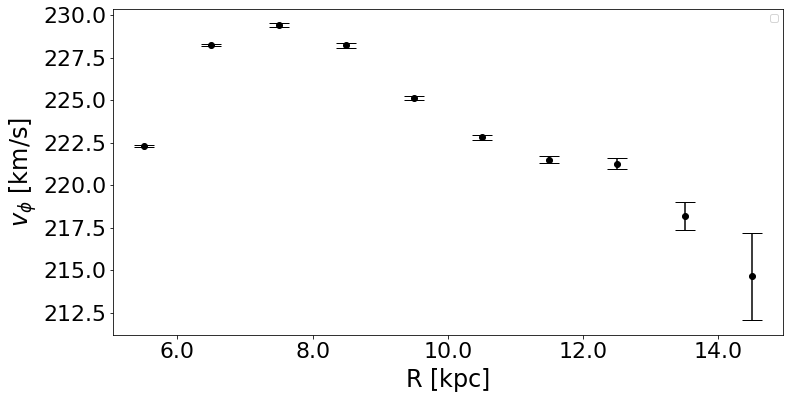

In [16]:
# OLD

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)
y = np.array(mean_rot_vel)

ax.scatter(x, -y, color='black', label='Mean')
ax.errorbar(x, -y, 
            yerr=bootstrap_vphi_error, color='black', linestyle='', capsize=10)




def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 24}
ax.set_xlabel(r'$\rm R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$\rm v_\phi$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)
plt.legend()

plt.savefig('mean_rotational_velocities_bootstrap.pdf', dpi = 300, bbox_inches='tight')

In [9]:
bin_rs

[5500.0, 6500.0, 7500.0, 8500.0, 9500.0, 10500.0, 11500.0, 13000.0]

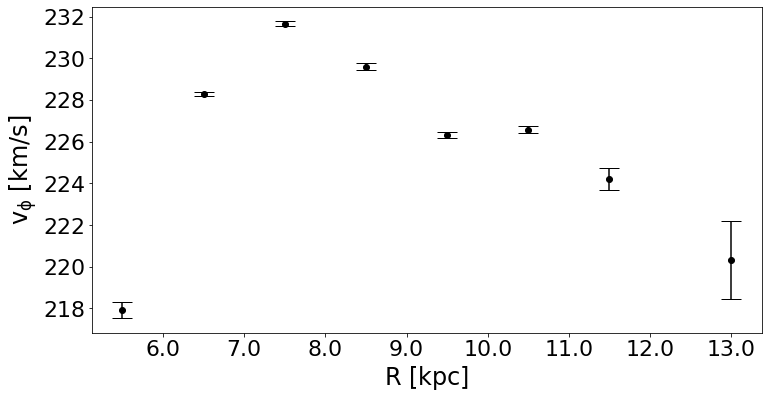

In [8]:
# NEW

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)
y = np.array(mean_rot_vel)

ax.scatter(x, -y, color='black', label='Mean')
ax.errorbar(x, -y, 
            yerr=bootstrap_vphi_error, color='black', linestyle='', capsize=10)




def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 24}
ax.set_xlabel(r'$\rm R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$\rm v_\phi$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)
#plt.legend()

plt.savefig('mean_rotational_velocities_bootstrap_June_cut_20_8_bins.pdf', dpi = 300, bbox_inches='tight')

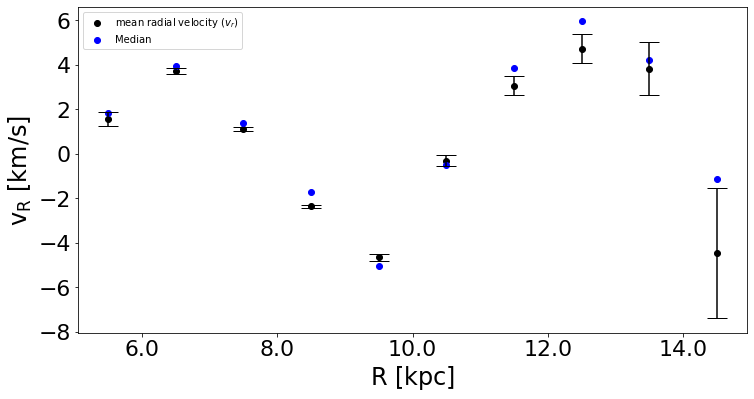

In [8]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)

y = np.array(mean_rad_vel)
ax.scatter(x, y, color='black', label=r'mean radial velocity ($v_r$)')
ax.errorbar(x, y, 
            yerr=bootstrap_vr_error, color='black', linestyle='', capsize=10)


ax.scatter(x, np.array(median_rad_vel), color='blue', label='Median')
# ax.errorbar(x, -y, 
#             yerr=bootstrap_vphi_error, color='blue', linestyle='', capsize=10)

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 24}
ax.set_xlabel(r'$\rm R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$\rm v_R$ [km/s]', fontdict= fontdict)

#ax.hlines(0, 5000, 15000)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

plt.legend()

#plt.savefig('mean_radial_velocities_bootstrap.pdf', dpi = 300, bbox_inches='tight')

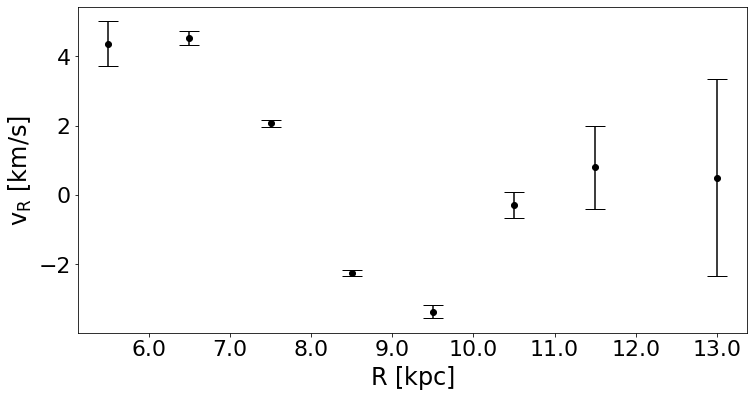

In [10]:
# NEW

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)

y = np.array(mean_rad_vel)
ax.scatter(x, y, color='black', label=r'mean radial velocity ($v_r$)')
ax.errorbar(x, y, 
            yerr=bootstrap_vr_error, color='black', linestyle='', capsize=10)


# ax.scatter(x, np.array(median_rad_vel), color='blue', label='Median')
# ax.errorbar(x, -y, 
#             yerr=bootstrap_vphi_error, color='blue', linestyle='', capsize=10)

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 24}
ax.set_xlabel(r'$\rm R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$\rm v_R$ [km/s]', fontdict= fontdict)

#ax.hlines(0, 5000, 15000)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# plt.legend()

plt.savefig('mean_radial_velocities_bootstrap_June_cut_20_8_bins.pdf', dpi = 300, bbox_inches='tight')